<div align="center">

# Filter Thresholding

</div>
<br>

An anomaly detector in Muzlin can be constructed simply. However, ther are many functional components that can be intergrated to get a better filter. One such component is the correct contamination level (e.g. when to draw the line between inliers and outliers)

Why is this useful?

By selecting the correct threshold, the constructed filter can more accurately determine the inliers from outliers and increase the filter's performance.

# Let's get started!

To begin, first it is recommended to install the necessary libraries to work with the notebooks



In [ ]:
!pip install -q muzlin[notebook]

Now that we have everything installed, let's import the precomputed encoded textual vectors.

In [1]:
import numpy as np
vectors = np.load('vectors.npy')

<br>
Now we can build our filter, but lets look at all the available thresholding methods.

In [ ]:
from muzlin.anomaly import OutlierDetector
from pyod.models.pca import PCA

# contamination = IQR() # Use the inter-quartile thresholding method from PyThresh
# contamination = 0.15 # Statically set the threshold at the 85th percentile of the outlier likelihood scores
# contamination = 120 # 120 percetile of the fitted decision scores this works for even outside the fitted range

# The first two methods above can be passed directly into the outlier detection method e.g
contamination = 0.15

# Initialize anomaly detection model 
od = PCA(contamination=contamination)

# Or you can pass them in to the class OutlierDetector contamination arg
# e.g clf = OutlierDetector(mlflow=False, detector=od, contamination=contamination)

# Note that the percentile contamination is the best approach for smalldatasets (<1000) or datasets that cover a broad field of topics

# Set mlflow to true to log the experiment
#mlflow.set_experiment('outlier_model')
clf = OutlierDetector(mlflow=False, detector=od)
clf.fit(vectors)
#mlflow.end_run()

<br>
While all the options above are nice, how can I fine tune and make sure I have the best threshold?
<br>
<br>
Great question!
<br>
actually there are a few ways this can be done, lets start with a visual look at the likelihood scores

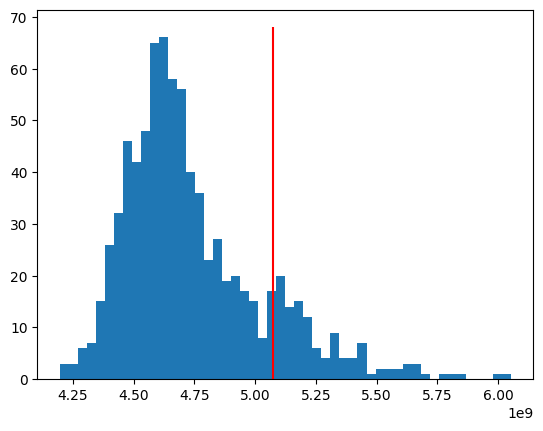

In [3]:
import matplotlib.pyplot as plt

scores = clf.decision_scores_

# Lets get the 85th percentile which was our inital contamination guess
perc = np.percentile(scores, 100 - contamination*100)

# Bin the data and we can see that our initial first guess was good (albeit too lenient)
# Here the red line is the threshold and we can see that first Gaussian distrubution represents
# the inlier data and the right tail is the outliers
plt.hist(scores, bins=50)
plt.vlines(perc, 0, 68, colors='r')
plt.show()

<br>
Another way to visualize this is to decompose the vectors and inspect the 3D plot of inliers and outliers

In [ ]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE


# Create a decomposition model and transform the data
decomp = TSNE(n_components=3, perplexity=5, random_state=42, init='pca', learning_rate='auto', metric='cosine')
#decomp = PCA_decomp(n_components=3)
vis_dims = decomp.fit_transform(vectors)

x = vis_dims[:, 0]
y = vis_dims[:, 1]
z = vis_dims[:, 2]

labels = clf.labels_

scatter_inliers = go.Scatter3d(x=x[labels==0], y=y[labels==0], z=z[labels==0], 
                               mode='markers', marker=dict(size=1, color='blue'), 
                               name='Inliers')
scatter_outliers = go.Scatter3d(x=x[labels==1], y=y[labels==1], z=z[labels==1], 
                                mode='markers', marker=dict(size=1, color='red'), 
                                name='Outliers')

# Create the figure with both scatter plots
fig = go.Figure(data=[scatter_inliers, scatter_outliers])


# Set the title
fig.update_layout(title_text='Inlier/Outlier Visualization',
                 width=600, height=600)

# Show the plot
fig.show()


## A better way?
<br>
While the methods above are helpfull, there are even better ways to fine-tune the threshold for your filter.
<br>
However, to do this we will need labled text to achieve this. Below is a semi-supervised approach.

In [5]:
from muzlin.encoders import HuggingFaceEncoder
from muzlin.anomaly import optimize_threshold

encoder = HuggingFaceEncoder()

# Note that this even works well for a few-shot setup as demonstrated below
labeled_text = ['Who is the current president of the USA?', 'What treatment raises endoplasmic reticulum stress?',
                'What dosage affects the kidneys?', 'Does taking too much folic acid affect kidney disease?']
real_labels = [1, 0, 1, 0,]

ref_vectors = encoder(labeled_text)
ref_vectors = np.array(ref_vectors)

fitted_scores = clf.decision_scores_
pred_scores = clf.decision_function(ref_vectors)


thresh_score1, thresh_perc1 = optimize_threshold(fitted_scores, pred_scores, real_labels, policy='balanced')
thresh_score2, thresh_perc3 = optimize_threshold(fitted_scores, pred_scores, real_labels, policy='soft')
thresh_score3, thresh_perc2 = optimize_threshold(fitted_scores, pred_scores, real_labels, policy='hard')

print(f'The balanced policy threshold percentage is {round(thresh_perc1, 2)}%')
print(f'The soft policy threshold percentage is {round(thresh_perc2, 2)}%')
print(f'The hard policy threshold percentage is {round(thresh_perc3, 2)}%')


The balanced policy threshold percentage is 83.31%
The soft policy threshold percentage is 79.11%
The hard policy threshold percentage is 85.41%


The thresholds above can be used to refit the model by passing the optimized threshold in as the contamination param.

<br>

But say now that you have many examples of labeled data (e.g. we say that all the fitted data is inliers and some evaluation dataset contains only outliers), well instead of using unsupervised or semi-supervised approaches we can use a fully supervised setup.

In [ ]:
from datasets import load_dataset
from muzlin.anomaly import OutlierDetector
from sklearn.linear_model import LogisticRegression

# Dummy dataset where all the context is definite outliers with respect to the RAG we have
ds = load_dataset('vjain/psych', trust_remote_code=True)

psych_text = ds['train']['text']

outlier_vectors = encoder(psych_text)
outlier_vectors = np.array(outlier_vectors)

od = LogisticRegression()

all_vectors = np.concatenate([vectors, outlier_vectors])
labels = np.zeros(len(all_vectors))
labels[len(vectors):] = 1

clf_sup = OutlierDetector(mlflow=False, detector=od, model='outlier_detector_sup.pkl')
clf_sup.fit(all_vectors, labels)


In [7]:
pred_labels = clf_sup.predict(ref_vectors)
print(pred_labels)

[1. 0. 0. 0.]
